# Comparison between cluster of controls and cluster of patients (CAD)

### Controls in the same size as cases are considered (same age/gender division), clustering, gene/pathways and endophenotype analysis are repeated. 
Sample preparation: 
- Controls are extracted from CAD_SOFT == 0
- Samples with family history (mother father or siblings) of heart disease and stroke are removeed
- Control samples are matched per age and sex with cases, total of 19032 with 14690 males and 4332 females

Analysis:
- Do we find a relationship between phenotype and cluster-associated genes / pathways? --> for each pair of groups, compute the correlation of estimates WMW.
- What are the associated endophenotypes? How many? What is the reference?
- clust internal cluster performance

In [2]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(clustAnalytics)
library(rlist)
library(ggsci)
library(stringr)
library(corrplot)
library(RColorBrewer)
library(ggvenn)


options(bitmapType = 'cairo', device = 'png')

fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
outFold <- sprintf('%sCAD_clustering/', fold_notebook)

setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
fold <- "OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/"

out_cases <- get(load(sprintf('%s/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', fold)))
out_controls <- get(load(sprintf('%s/tscore_corrPCs_zscaled_clusterControls_PGmethod_HKmetric.RData', fold)))
out_controls_original <- get(load(sprintf('%s/tscore_corrPCs_original_clusterControls_PGmethod_HKmetric.RData', fold)))

gene_cases <- get(load(sprintf('%s/tscoreOriginal_corrPCs_tscoreClusterCases_featAssociation.RData', fold)))
gene_controls <- get(load(sprintf('%s/tscoreOriginal_corrPCs_tscoreClusterControls_featAssociation.RData', fold)))
gene_controls_original <- get(load(sprintf('%s/ClusterOriginal_tscoreOriginal_corrPCs_tscoreClusterCases_featAssociation.RData', fold)))

path_cases <- get(load(sprintf('%s/pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData', fold)))
path_controls <- get(load(sprintf('%s/pathOriginal_filtJS0.2_corrPCs_tscoreClusterControls_featAssociation.RData', fold)))
path_controls_original <- get(load(sprintf('%s/ClusterOriginal_pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData', fold)))

endop_cases <- read_tsv(sprintf('%stscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_combined.txt', fold), show_col_types = FALSE)
endop_controls <- read_tsv(sprintf('%stscore_corrPCs_zscaled_clusterControls_PGmethod_HKmetric_phenoAssociation_GLM_combined.txt', fold), show_col_types = FALSE)
endop_controls_original <- read_tsv(sprintf('%stscore_corrPCs_original_clusterControls_PGmethod_HKmetric_phenoAssociation_GLM_combined.txt', fold), show_col_types = FALSE)

colorFile <- sprintf('%scolor_pheno_type_UKBB.txt', fold_notebook)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.5
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘clustAnalytics’


The following object is masked from ‘package:ggp

In [111]:
#### plot cluster distributions
plot_stat_cases_controls <- function(cases, controls, outFold, name_comp_controls = "Controls", width_pl = 3, height_pl = 5){

cl_measure_ca <- cases$info_tune$coverage_and_conductance
cl_measure_co <- controls$info_tune$coverage_and_conductance

tmp_ca <- data.frame(type = rep("Cases", cases$info_tune$n_clusters), 
                     n_samples = sapply(sort(unique(cases$cl_best$gr)), function(x) sum(cases$cl_best$gr == x)), 
                     gr = sort(unique(cases$cl_best$gr)))

tmp_co <- data.frame(type = rep("Controls", controls$info_tune$n_clusters), 
                     n_samples = sapply(sort(unique(controls$cl_best$gr)), function(x) sum(controls$cl_best$gr == x)), 
                     gr = sort(unique(controls$cl_best$gr)))

df <- rbind(tmp_ca, tmp_co)
df$gr <- paste0('gr', df$gr)
max_gr <- max(as.numeric(sapply(unique(as.character(df$gr)), function(x) strsplit(x, 'gr')[[1]][2])))
df$gr <- factor(df$gr, levels = paste0('gr', 1:max_gr))

if(length(unique(df$gr)) > 20){
    getPalette <- colorRampPalette(pal_d3("category20")(20))
    color_gr <- getPalette(length(levels(df$gr)))
}else{
    color_gr <- pal_d3("category20")(length(levels(df$gr)))
}

n_samples_tot <- df %>% group_by(type) %>% summarise(n_samples_tot = sum(n_samples)) %>% pull(n_samples_tot) %>% max()

pl <- ggplot(data = df, aes(x = type, y = n_samples, fill = gr))+
    geom_bar(alpha = 0.7, width = 0.5, stat = 'identity', color = "black")+
    ylab('n. samples')+ 
    theme_bw()+ 
    geom_text(inherit.aes = FALSE, 
              data = data.frame(type = c('Cases', 'Controls'), 
                                n_samples = rep(n_samples_tot,2), 
                                coverage_and_conductance = c(cl_measure_ca, cl_measure_co)), 
              aes(x = type, y = n_samples, label = paste0("Cl. quality:\n", round(coverage_and_conductance, 3))), 
              vjust = -0.5, hjust = 0.5, size = 3, color = 'black')+
    theme(legend.position = 'right', axis.title.x = element_blank(),
          legend.text = element_text(size = 8), legend.title = element_blank())+
    ylim(c(0, n_samples_tot + 1000))+
    scale_fill_manual(values = color_gr)+
    guides(fill = guide_legend(ncol = max(1, round(length(levels(df$gr))/10))))

print(pl)

ggsave(filename = sprintf('%scompare_Cases_%s_dist_clusters.pdf', outFold, name_comp_controls), 
       plot = pl, width = width_pl, height = height_pl)

return(df)

}

#### plot correlation WMW t-scores and pathscores across tissues
plot_corr_feat <- function(cases, controls, outFold, type_data, name_comp_controls = "Controls", width_pl = 5, height_pl = 5){

comp_cases <- sort(unique(cases$test_feat[[1]]$comp))
comp_controls <- sort(unique(controls$test_feat[[1]]$comp))

# split comp column by _vs_all with stringr package

feat_cases <- lapply(cases$test_feat, function(x) 
    x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))) %>%
    bind_rows() 

feat_controls <- lapply(controls$test_feat, function(x) x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))) %>%
    bind_rows() 

feat_tot <- rbind(feat_cases, feat_controls)
comp_all <- unique(feat_tot$comp_type)
comp_cases <- unique(feat_cases$comp_type)
comp_controls <- unique(feat_controls$comp_type)

cor_mat <- matrix(nrow = length(comp_cases), ncol = length(comp_controls))
for(i in 1:length(comp_cases)){
    ci_cases <- comp_cases[i]
    vi <- feat_tot %>% filter(comp_type == ci_cases) 
    for(j in 1:length(comp_controls)){
        cj_controls <- comp_controls[j]
        vj <- feat_tot %>% filter(comp_type == cj_controls) 
        # check order is correct
        if(!identical(vi$feat_tissue, vj$feat_tissue)){stop(sprintf('Order of feat_tissue is not the same in %s and %s', ci_cases, cj_controls))}
        cor_mat[i,j] <- cor(vi$estimates, vj$estimates, method = 'pearson')
    }
}
colnames(cor_mat) <- comp_controls
rownames(cor_mat) <- comp_cases

pdf(file = sprintf('%scorr_%s_comapre_Cases_%s.pdf', outFold, type_data, name_comp_controls), 
    width = width_pl, height = height_pl, compress = F, pointsize = 12)
    corrplot(cor_mat, 
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))
dev.off()

# plot NMI
corrplot(cor_mat, 
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))

return(cor_mat)

}


#### plot intersection of cluster-specific genes/pathways
plot_intersection <- function(cases, controls, outFold, pval_corr_thr = 0.01, type_data, name_comp_controls = "Controls", width_pl = 5, height_pl = 5){

comp_cases <- sort(unique(cases$test_feat[[1]]$comp))
comp_controls <- sort(unique(controls$test_feat[[1]]$comp))

feat_sign_cases <- lapply(cases$test_feat, function(x) 
    x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(type = "Cases") %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr)) %>%
    bind_rows()


feat_sign_controls <- lapply(controls$test_feat, function(x) 
    x %>% 
        mutate(feat_tissue = paste0(feat, '_', tissue)) %>%
        mutate(type = "Controls") %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr)) %>%
    bind_rows() 

feat_sign_tot <- rbind(feat_sign_cases, feat_sign_controls)

common_feat <- intersect(unique(feat_sign_cases$feat_tissue), unique(feat_sign_controls$feat_tissue))

df <- feat_sign_tot %>% 
    mutate(common = case_when(feat_tissue %in% common_feat ~ 'common', TRUE ~ 'unique'))
df$common <- factor(df$common, levels = c('unique', 'common'))

futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

tmp <- venn.diagram(list(Cases = unique(feat_sign_cases$feat_tissue), Controls = unique(feat_sign_controls$feat_tissue)), 
  fill = c("red", "blue"),
  alpha = c(0.5, 0.5), 
  lty = 2,
  filename = NULL, 
  lwd = 1,
  cex = 2,
  cat.cex = 2)
pdf(file = sprintf('%sVenn_sign%s_Cases_%s.pdf', outFold, type_data, name_comp_controls))
    grid.draw(tmp)
dev.off()
type_data_pl <- ifelse(type_data == 'Tscores', 'genes', 'pathways')
# add boxplot of estimates from df, divide per common/unique, use ggplot2
pl <- ggplot(data = df, aes(x = common, y = abs(estimates)))+
    geom_boxplot(outlier.size = 0.5)+
    stat_compare_means(method = 'wilcox.test', label = 'p.format', label.x = 1.5, size = 3)+
    facet_wrap(~type, ncol = 2)+
    theme_bw()+ 
    xlab(sprintf('Cluster-specific %s', type_data_pl)) + 
    ylab('|WMW estimates|')+
    theme(legend.position = 'none')
print(pl)
# save plot
ggsave(filename = sprintf('%sboxplot_sign%s_Cases_%s_common.pdf', outFold, type_data, name_comp_controls), 
       plot = pl, width = width_pl, height = height_pl)


}

# endophenotype plot
endopheno_forest_plot <- function(colorFile, res_pheno, pval_pheno = 0.0001, outFold, type_input, type_cluster) { 

    pheno_ann <- read.delim(colorFile, header = T, stringsAsFactors = F)

    id_keep <- unique(res_pheno$pheno_id[res_pheno$pvalue <= pval_pheno | res_pheno$pval_corr <= 0.05])
    id_keep <- id_keep[!is.na(id_keep)]
    df_red <- res_pheno %>% filter(pheno_id %in% id_keep) %>% 
        mutate(new_id = ifelse(is.na(meaning), paste(Field),paste(Field, meaning, sep = '\n'))) %>%
        mutate(sign = ifelse(pval_corr <= 0.05, 'yes', 'no')) %>%
        mutate(type_res = ifelse(type_pheno == 'CONTINUOUS', 'beta', 'OR')) %>%
        mutate(OR_or_Beta = ifelse(se_beta > 100, NA, OR_or_Beta)) %>%
        mutate(CI_low = ifelse(se_beta > 100, NA, CI_low)) %>% 
        mutate(CI_up = ifelse(se_beta > 100, NA, CI_up))
  
    df_red$new_id <- factor(df_red$new_id, levels = unique(df_red$new_id))
    df_red$comp <- factor(df_red$comp, levels = unique(df_red$comp))
    df_red$pheno_type <- factor(df_red$pheno_type, levels = unique(df_red$pheno_type))
    df_red$sign <- factor(df_red$sign, levels = c('no', 'yes'))
    df_red$type_res <- factor(df_red$type_res, levels = c('OR', 'beta'))
  
    df_red_for_ann <- df_red[!duplicated(df_red$new_id),]
    pheno_ann_red1 <- pheno_ann[match(df_red_for_ann$pheno_type[df_red_for_ann$type_pheno != 'CONTINUOUS'], pheno_ann$pheno_type), ]
    pheno_ann_red2 <- pheno_ann[match(df_red_for_ann$pheno_type[df_red_for_ann$type_pheno == 'CONTINUOUS'], pheno_ann$pheno_type), ]
  
    len_w <- length(unique(df_red$comp))
    len_h <- length(unique(df_red$pheno_id))
    # change labels 
    labs_new <- sapply(as.character(unique(df_red$comp)), function(x) strsplit(x, split = '_vs_all')[[1]][1])
    names(labs_new) <- as.character(unique(df_red$comp))
  
  P <- length(unique(df_red$comp))
  gr_color <- pal_d3(palette = 'category20')(P)
  
  if(any(df_red$type_pheno != 'CONTINUOUS')){
    
    pl_OR <-  ggplot(subset(df_red, type_pheno != 'CONTINUOUS'), aes(x = new_id, y = OR_or_Beta, shape = sign))+
      geom_point()+geom_errorbar(aes(ymin=CI_low, ymax=CI_up), width=.2, position=position_dodge(0.05))+
      theme_bw()+ 
      ylab('Adjusted OR (95% CI)')+ geom_hline(yintercept = 1, linetype = 'dashed', color = 'grey40')+
      facet_wrap(comp~.,  nrow = 1, strip.position="top", labeller = labeller(comp = labs_new))+
      theme(legend.position = 'none', plot.title = element_text(size=9), axis.title.y = element_blank(), axis.title.x = element_text(size=8),
            axis.text.x = element_text(size = 7, angle = 45, hjust = 1), axis.text.y = element_text(size = 7, colour = pheno_ann_red1$color),
            strip.text = element_text(size=8, color = 'white', face = 'bold'))+
      scale_shape_manual(values=c(1, 19))+
      scale_color_manual(values=pheno_ann_red1$color)+
      scale_y_continuous(trans='log', labels = scales::number_format(accuracy = 0.01))+
      coord_flip()
    
    pl_OR <- ggplot_gtable(ggplot_build(pl_OR))
    stripr <- which(grepl('strip-t', pl_OR$layout$name))
    fills <- gr_color
    k <- 1
    for (i in stripr) {
      j <- which(grepl('rect', pl_OR$grobs[[i]]$grobs[[1]]$childrenOrder))
      pl_OR$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
      k <- k+1
    }
  }
  
  if(any(df_red$type_pheno == 'CONTINUOUS')){
    
    pl_beta <-  ggplot(subset(df_red, type_pheno == 'CONTINUOUS'), aes(x = new_id, y = OR_or_Beta, shape = sign))+
      geom_point()+geom_errorbar(aes(ymin=CI_low, ymax=CI_up), width=.2, position=position_dodge(0.05))+
      theme_bw()+ 
      ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
      facet_wrap(comp~., nrow = 1, strip.position="top",  labeller = labeller(comp = labs_new))+
      theme(legend.position = 'none', plot.title = element_text(size=9), axis.title.y = element_blank(), axis.title.x = element_text(size=8),
            axis.text.x = element_text(size = 7, angle = 45, hjust = 1), axis.text.y = element_text(size = 7,  colour = pheno_ann_red2$color), 
            strip.text = element_text(size=8, color = 'white', face = 'bold'))+
      scale_shape_manual(values=c(1, 19))+
      scale_color_manual(values=pheno_ann_red2$color)+
      coord_flip()

    sum_c <- sum(df_red$type_pheno == 'CONTINUOUS')
    sum_notc <- sum(df_red$type_pheno != 'CONTINUOUS')

    ratio_OR_beta <- ifelse(sum_c > sum_notc, (sum_notc*1.5)/sum_c + 0.5, (sum_c*1.5)/sum_notc+0.5)
    print(ratio_OR_beta)


    pl_beta <- ggplot_gtable(ggplot_build(pl_beta))
    stripr <- which(grepl('strip-t', pl_beta$layout$name))
    fills <- gr_color
    k <- 1
    for (i in stripr) {
      j <- which(grepl('rect', pl_beta$grobs[[i]]$grobs[[1]]$childrenOrder))
      pl_beta$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
      k <- k+1
    }
  }
  
  if(any(df_red$type_pheno == 'CONTINUOUS') & any(df_red$type_pheno != 'CONTINUOUS')){
    tot_pl <- ggarrange(plotlist = list(pl_beta, pl_OR), align = 'v', ncol = 1, heights = c(1, ratio_OR_beta))
  }else{
    if(any(df_red$type_pheno == 'CONTINUOUS')){
      tot_pl <- pl_beta
    }else{
      tot_pl <- pl_OR
    }
  }
  
  ggsave(filename = sprintf('%stscore_%s_cluster%s_PGmethod_HKmetric_phenoAssociation_GLM_betaOR_Integrated.pdf', outFold, type_input, type_cluster), 
         width = len_w+3, height = len_h*0.2+2, plot = tot_pl, device = 'pdf')

      return(tot_pl)
}

#### plot correlation beta endophenotypes (only in common for each pair of groups)
plot_corr_pheno <- function(cases, controls, outFold, pval_corr_thr = 0.05, name_comp_controls = "Controls", width_pl = 5, height_pl = 5){

pheno_cases <- cases %>%
        mutate(type = "Cases") %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))

pheno_controls <- controls %>%
        mutate(type = "Controls") %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1]))

pheno_tot <- rbind(pheno_cases, pheno_controls)
comp_all <- unique(pheno_tot$comp_type)
comp_cases <- unique(pheno_cases$comp_type)
comp_controls <- unique(pheno_controls$comp_type)

cor_mat <- matrix(nrow = length(comp_cases), ncol = length(comp_controls))
for(i in 1:length(comp_cases)){
    ci_cases <- comp_cases[i]
    vi <- pheno_tot %>% filter(comp_type == ci_cases) %>% filter(!is.na(beta))
    for(j in 1:length(comp_controls)){
        cj_controls <- comp_controls[j]
        vj <- pheno_tot %>% filter(comp_type == cj_controls) %>% filter(!is.na(beta))
        # check order is correct
        if(!identical(vi$pheno_id, vj$pheno_id)){
                p_common <- intersect(vi$pheno_id, vj$pheno_id)
                print(sprintf('N. common pheno for %s and %s = %i', ci_cases, cj_controls, length(p_common)))
                vi_new <-  vi[match(p_common, vi$pheno_id),]
                vj_new <-  vj[match(p_common, vj$pheno_id),]
        }else{
                vi_new <- vi
                vj_new <- vj
        }
        cor_mat[i,j] <- cor(vi_new$beta, vj_new$beta, method = 'pearson')
    }
}
colnames(cor_mat) <- comp_controls
rownames(cor_mat) <- comp_cases

### TODO: ADD x FOR NON SIGNIFICANT RESULTS!

pdf(file = sprintf('%scorr_Endopheno_comapre_Cases_%s.pdf', outFold, name_comp_controls), 
    width = width_pl, height = height_pl, compress = F, pointsize = 12)
    corrplot(cor_mat, 
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))
dev.off()

# plot NMI
corrplot(cor_mat, 
        tl.col = "black", # text color
         tl.cex=1.2,
         method = 'color', 
         tl.srt=45, 
         cl.align.text='c',
         addCoef.col = "black",
         na.label = 'square', 
         na.label.col = 'darkgrey', 
         is.corr = F, 
         number.cex=0.9, 
         mar = c(0,7,7,0))

return(cor_mat)

}



NULL


   Family_history     ICD9-10_OPCS4        Medication       Medications 
                6                39                 1                84 
Physical_activity 
                1 

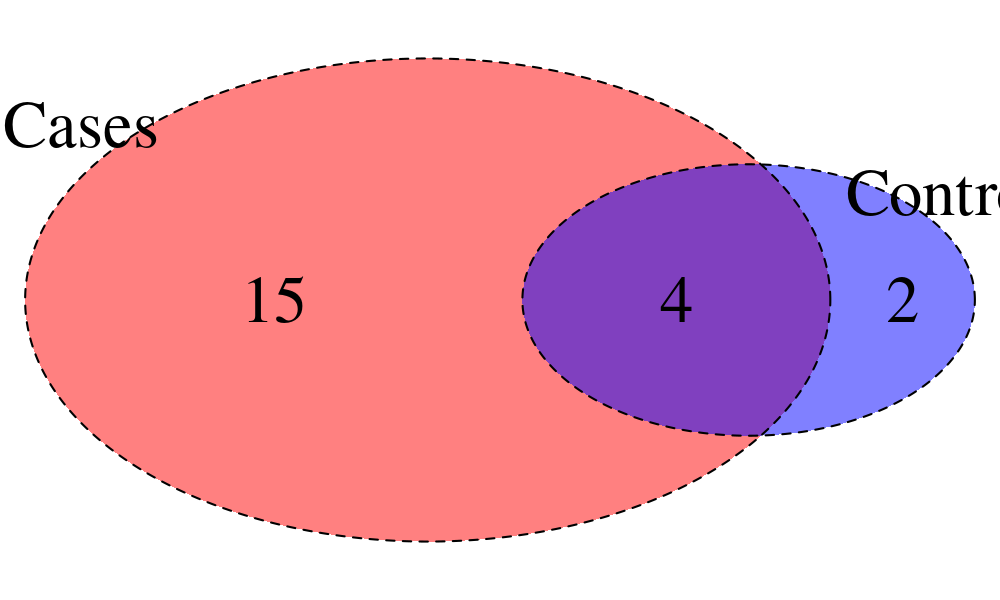

In [99]:
# plot endophenotype results
### PLOT INTERSECTION, TO FINISH
cases <- endop_cases
controls <- endop_controls
pval_corr_thr <- 0.05

common_pheno <- intersect(unique(cases$pheno_id), unique(controls$pheno_id))

comp_cases <- sort(unique(cases$comp))
comp_controls <- sort(unique(controls$comp))

pheno_sign_cases <- cases %>%
        mutate(type = "Cases") %>%
        mutate(comp_type = paste0("Cases_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr) 

pheno_sign_controls <- controls %>%
        mutate(type = "Controls") %>%
        mutate(comp_type = paste0("Controls_", stringr::str_split_fixed(comp, pattern = "_vs_all", 2)[,1])) %>%
        filter(pval_corr <= pval_corr_thr) 

futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
tmp <- venn.diagram(list(Cases = unique(pheno_sign_cases$pheno_id), Controls = unique(pheno_sign_controls$pheno_id)), 
  fill = c("red", "blue"),
  alpha = c(0.5, 0.5), 
  lty = 2,
  filename = NULL, 
  lwd = 1,
  cex = 2,
  cat.cex = 2)
grid.draw(tmp)
#pdf(file = sprintf('%sVenn_signEndopheno_Cases_%s.pdf', outFold, name_comp_controls))
#    grid.draw(tmp)
#dev.off()

un_p <- setdiff(unique(cases$pheno_id), common_pheno)
a = cases[cases$pheno_id %in% un_p,]
table(a[!duplicated(a$pheno_id),"pheno_type"])

type,n_samples,gr
<chr>,<int>,<fct>
Cases,6105,gr1
Cases,4783,gr2
Cases,2831,gr3
Cases,4520,gr4
Cases,784,gr5
Controls,6682,gr1
Controls,2330,gr2
Controls,4288,gr3
Controls,4739,gr4


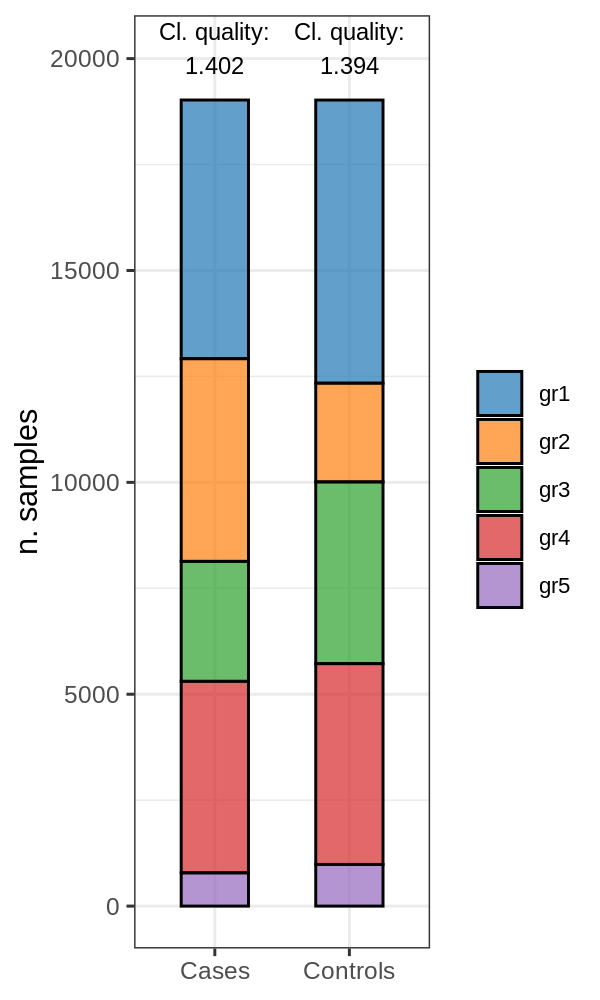

In [5]:
options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 200)
plot_stat_cases_controls(out_cases, out_controls, outFold, name_comp_controls = "Controls")


,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5
Cases_gr1,0.77038143,-0.07328175,-0.18420292,-0.2923858,0.74443300
Cases_gr2,-0.06969135,0.01588216,-0.86860301,0.9192241,-0.06689806
Cases_gr3,-0.07205197,0.92698519,-0.05038212,-0.0215378,-0.06895577
Cases_gr4,-0.11710735,-0.12003263,0.93229650,-0.8439497,-0.11564780
Cases_gr5,0.71928812,-0.06227492,-0.22354093,-0.2233825,0.71985307


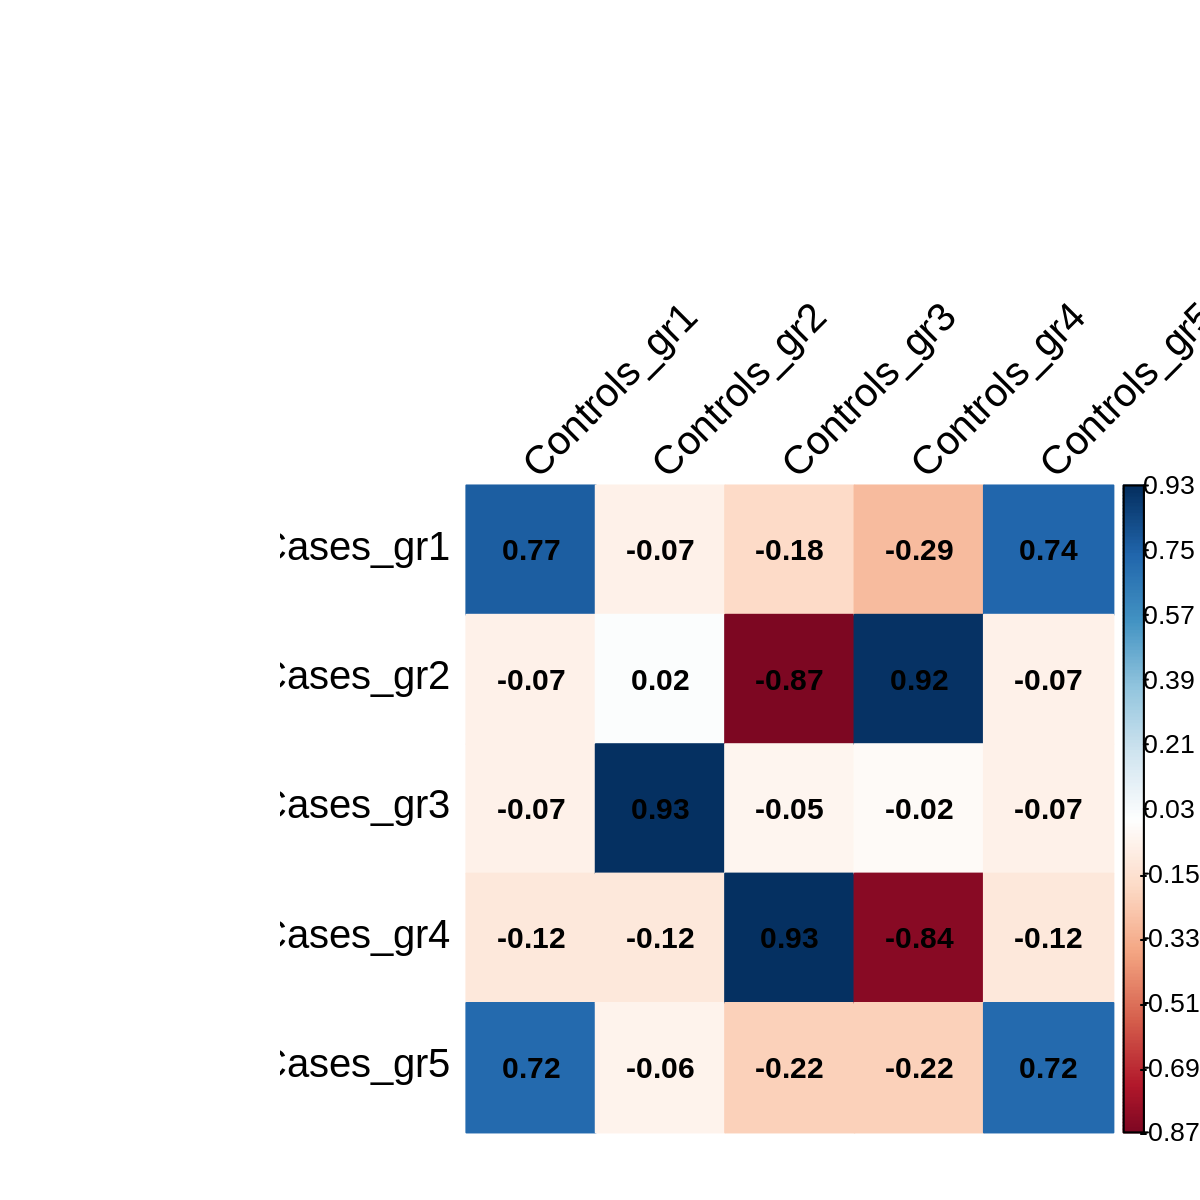

,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5
Cases_gr1,0.8294683,-0.499280764,-0.3185019,-0.4279636,0.8006615
Cases_gr2,-0.3481808,0.287691963,-0.5849430,0.8894620,-0.3093678
Cases_gr3,-0.4929365,0.611204249,0.1177653,0.2105020,-0.4754648
Cases_gr4,-0.3485376,-0.004601903,0.9021562,-0.5262824,-0.3680136
Cases_gr5,0.7791850,-0.457151785,-0.3461526,-0.3627837,0.7669097


[1] "N. common pheno for Cases_gr1 and Controls_gr1 = 504"
[1] "N. common pheno for Cases_gr1 and Controls_gr2 = 504"
[1] "N. common pheno for Cases_gr1 and Controls_gr3 = 504"
[1] "N. common pheno for Cases_gr1 and Controls_gr4 = 504"
[1] "N. common pheno for Cases_gr1 and Controls_gr5 = 499"
[1] "N. common pheno for Cases_gr2 and Controls_gr1 = 504"
[1] "N. common pheno for Cases_gr2 and Controls_gr2 = 504"
[1] "N. common pheno for Cases_gr2 and Controls_gr3 = 504"
[1] "N. common pheno for Cases_gr2 and Controls_gr4 = 504"
[1] "N. common pheno for Cases_gr2 and Controls_gr5 = 499"
[1] "N. common pheno for Cases_gr3 and Controls_gr1 = 504"
[1] "N. common pheno for Cases_gr3 and Controls_gr2 = 504"
[1] "N. common pheno for Cases_gr3 and Controls_gr3 = 504"
[1] "N. common pheno for Cases_gr3 and Controls_gr4 = 504"
[1] "N. common pheno for Cases_gr3 and Controls_gr5 = 499"
[1] "N. common pheno for Cases_gr4 and Controls_gr1 = 503"
[1] "N. common pheno for Cases_gr4 and Controls_gr2 = 50

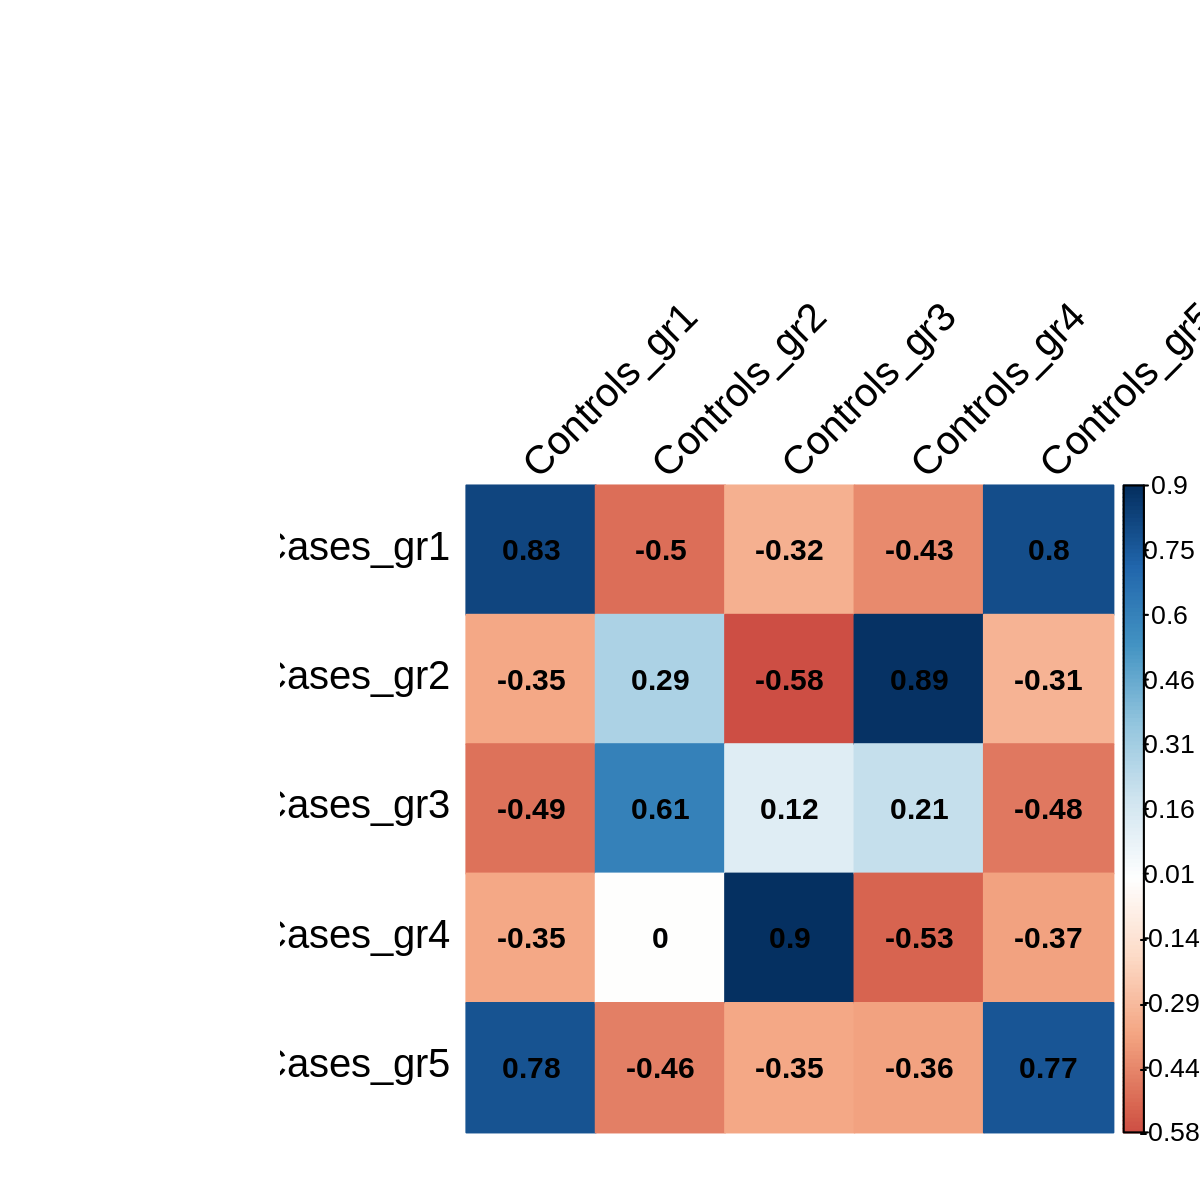

,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5
Cases_gr1,0.046151197,0.128345424,0.05200723,-0.124582139,0.146831007
Cases_gr2,0.095434545,0.005513124,-0.14742310,0.013472993,-0.119754562
Cases_gr3,-0.006347569,-0.135219342,-0.03137481,0.149164403,0.030873440
Cases_gr4,-0.151824449,0.029722053,0.15285202,-0.003802542,-0.023757399
Cases_gr5,-0.163184867,0.054246826,-0.06725979,0.198760047,-0.004772059


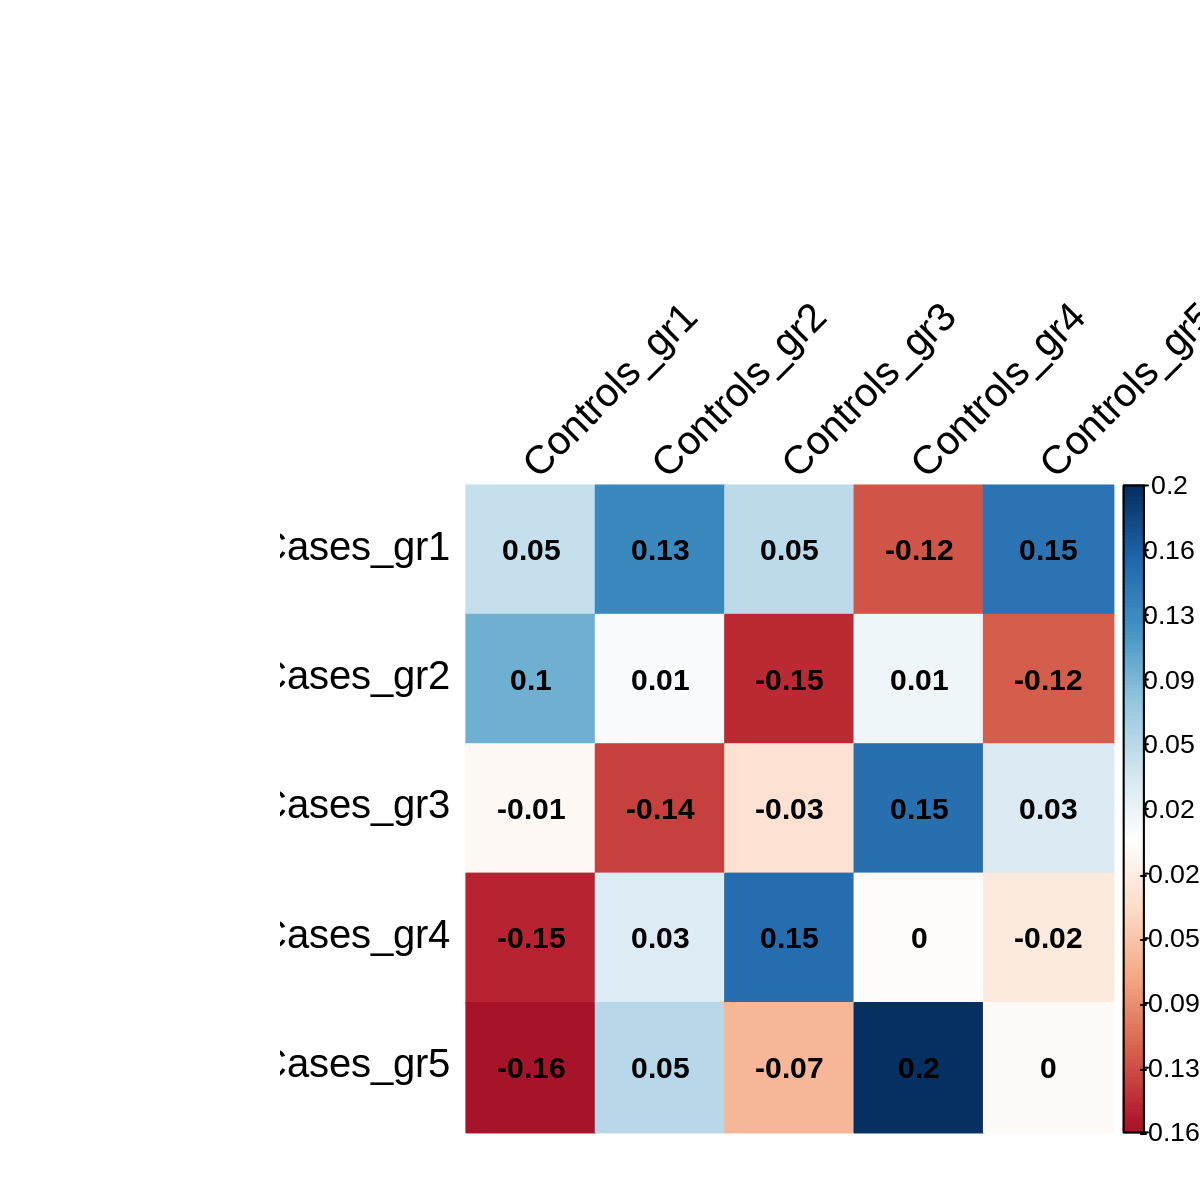

In [112]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 200)
plot_corr_feat(gene_cases, gene_controls, outFold, type_data = "Tscores", name_comp_controls = "Controls", width_pl = 6, height_pl = 6)
plot_corr_feat(path_cases, path_controls, outFold, type_data = "Pathscore", name_comp_controls = "Controls", width_pl = 6, height_pl = 6)
plot_corr_pheno(endop_cases, endop_controls, outFold, name_comp_controls = "Controls", width_pl = 6, height_pl = 6)

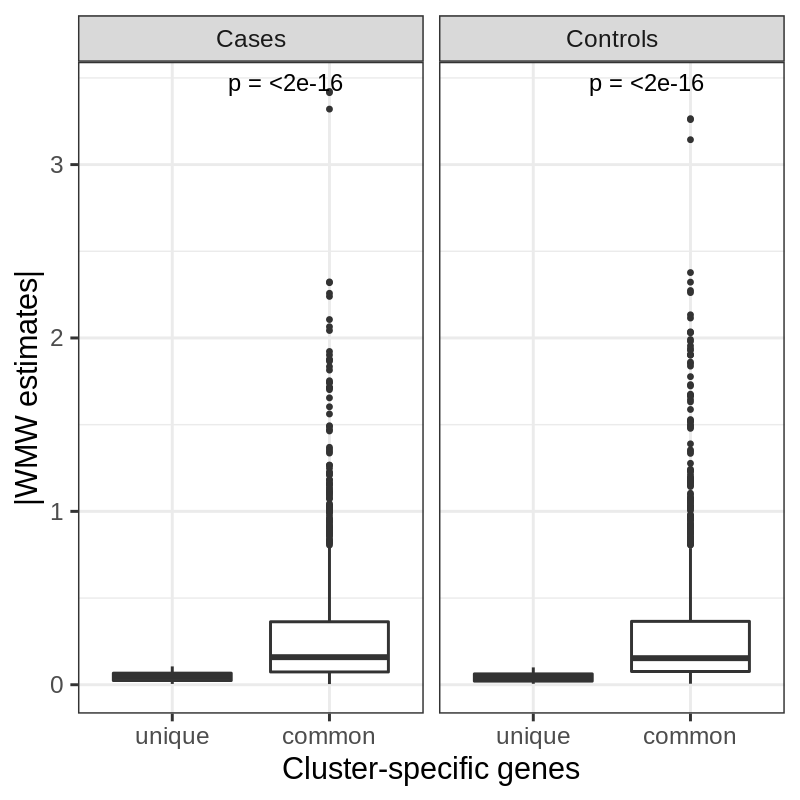

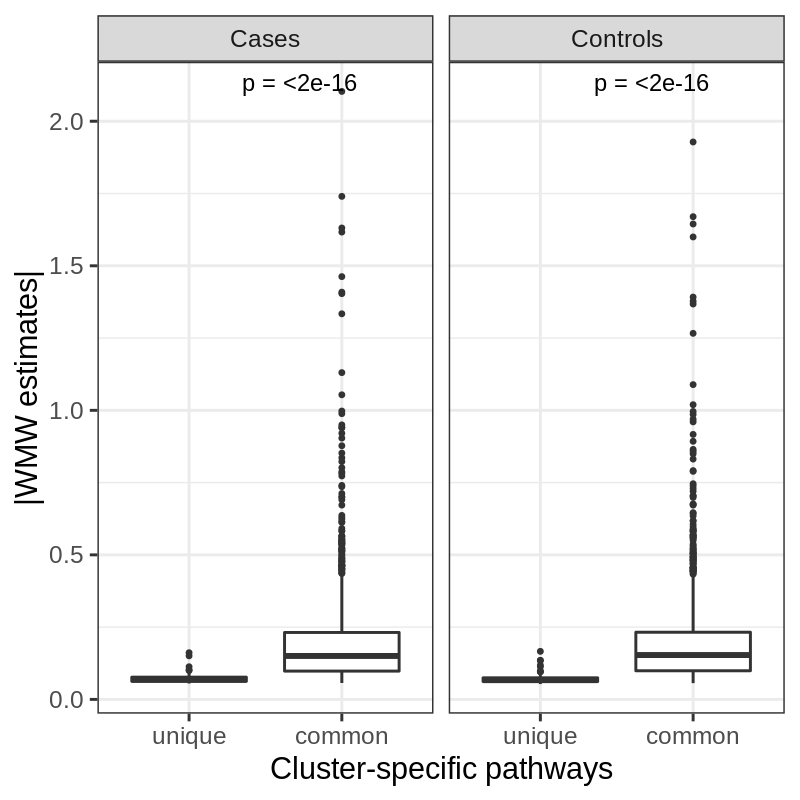

In [81]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200)
plot_intersection(gene_cases, gene_controls, outFold, pval_corr_thr = 0.01, type_data = "Tscores", name_comp_controls = "Controls", width_pl = 4, height_pl = 4)
plot_intersection(path_cases, path_controls, outFold, pval_corr_thr = 0.01, type_data = "Pathscores", name_comp_controls = "Controls", width_pl = 4, height_pl = 4)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


[1] 0.8


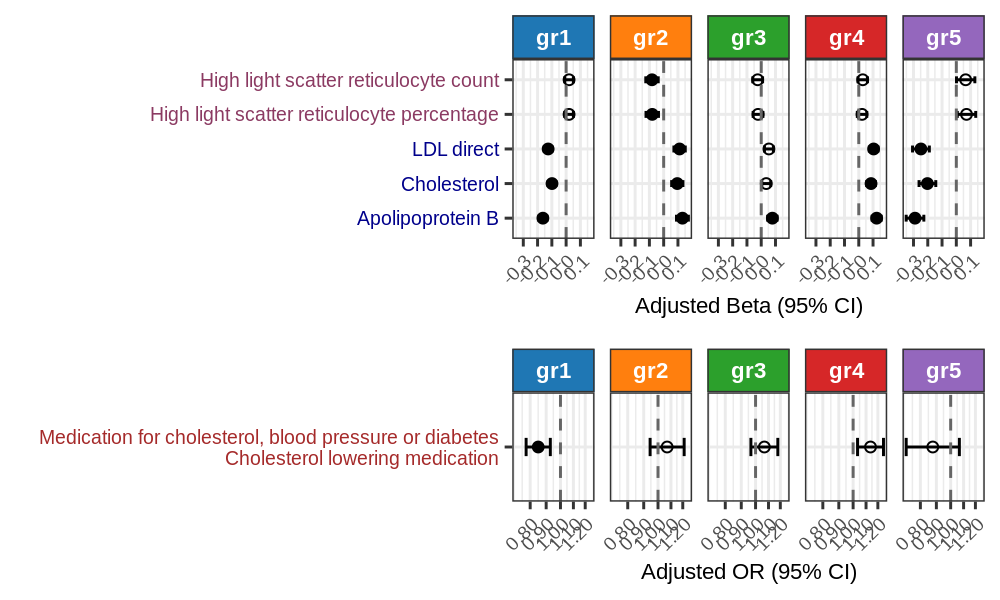

In [110]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
endopheno_forest_plot(colorFile, endop_controls, pval_pheno = 0.0001, outFold, type_input = 'zscaled', type_cluster = 'Controls')

### Conclusions on cases vs controls comparison:
- the number of groups is the same, with a similar fraction of cases distribution and cluster quality
- Indeed, when looking at association of genes with clusters, there are some groups in cases that are more correlated with other in controls, also true for pathways but to a lesser extent.
- We can then assume that cas 1 --> con 1, cas 2 --> con 4, cas 3 --> con 2, cas 4 --> con 3, cas 5 --> con 5
- When looking at cluster-specific genes and pathways, mostly are shared among cases and controls. Those not in common do not have the strongest effect size on the partition.

type,n_samples,gr
<chr>,<int>,<fct>
Cases,6105,gr1
Cases,4783,gr2
Cases,2831,gr3
Cases,4520,gr4
Cases,784,gr5
Controls,158,gr1
Controls,399,gr2
Controls,270,gr3
Controls,4652,gr4


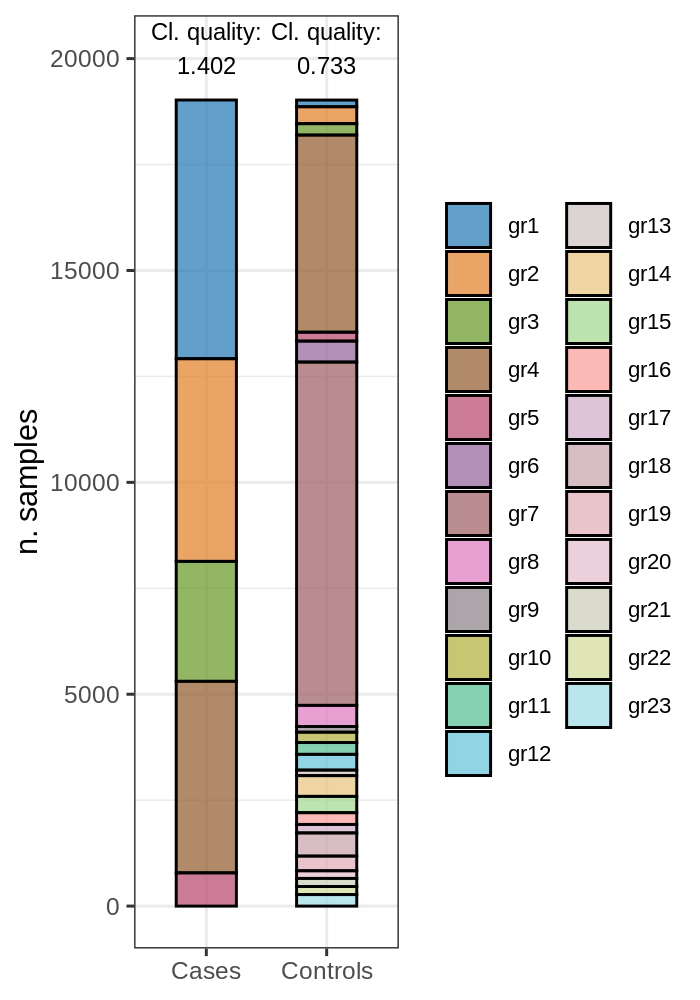

In [9]:
options(repr.plot.width = 3.5, repr.plot.height = 5, repr.plot.res = 200)
plot_stat_cases_controls(out_cases, out_controls_original, outFold, name_comp_controls = "ControlsOriginal", width_pl = 3.5, height_pl = 5)

,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5,Controls_gr6,Controls_gr7,Controls_gr8,Controls_gr9,Controls_gr10,Controls_gr11,Controls_gr12,Controls_gr13,Controls_gr14,Controls_gr15,Controls_gr16,Controls_gr17
Cases_gr1,-0.052922530,0.047447661,-0.02309069,-0.005424900,-0.018605802,-0.02748157,-0.035845153,6.695139e-05,-0.004918709,-0.011162440,-0.005941941,-0.0293201053,0.009400578,-0.02196414,0.014938092,-0.00811160,0.01453179
Cases_gr2,0.615490532,-0.560968484,-0.01265763,0.060591969,0.462992641,0.45658780,0.406518058,-1.064895e-01,0.102312556,0.291396636,0.018044539,0.3156022421,-0.250500197,0.32765733,0.242904450,0.16997530,-0.05536290
Cases_gr3,-0.015892249,0.013111037,-0.01258468,-0.032453121,0.003936942,0.03062752,0.017100620,-1.743590e-02,-0.003761886,-0.002499941,-0.038541885,-0.0039038262,0.050090984,-0.01144626,-0.007260278,-0.01811356,-0.01064012
Cases_gr4,-0.562489780,0.518410474,0.04422747,-0.032894349,-0.453141920,-0.45245371,-0.391893225,1.274310e-01,-0.094911433,-0.281428461,0.015060955,-0.2811215705,0.211288708,-0.30631963,-0.245854650,-0.15234098,0.05789121
Cases_gr5,0.004138627,-0.006284342,-0.02452476,0.008289593,0.006557064,0.00698005,-0.006090437,-9.649477e-03,-0.007517565,0.013486972,0.023094941,0.0001371055,-0.016088592,0.01025331,0.040799507,0.01179095,0.01323718


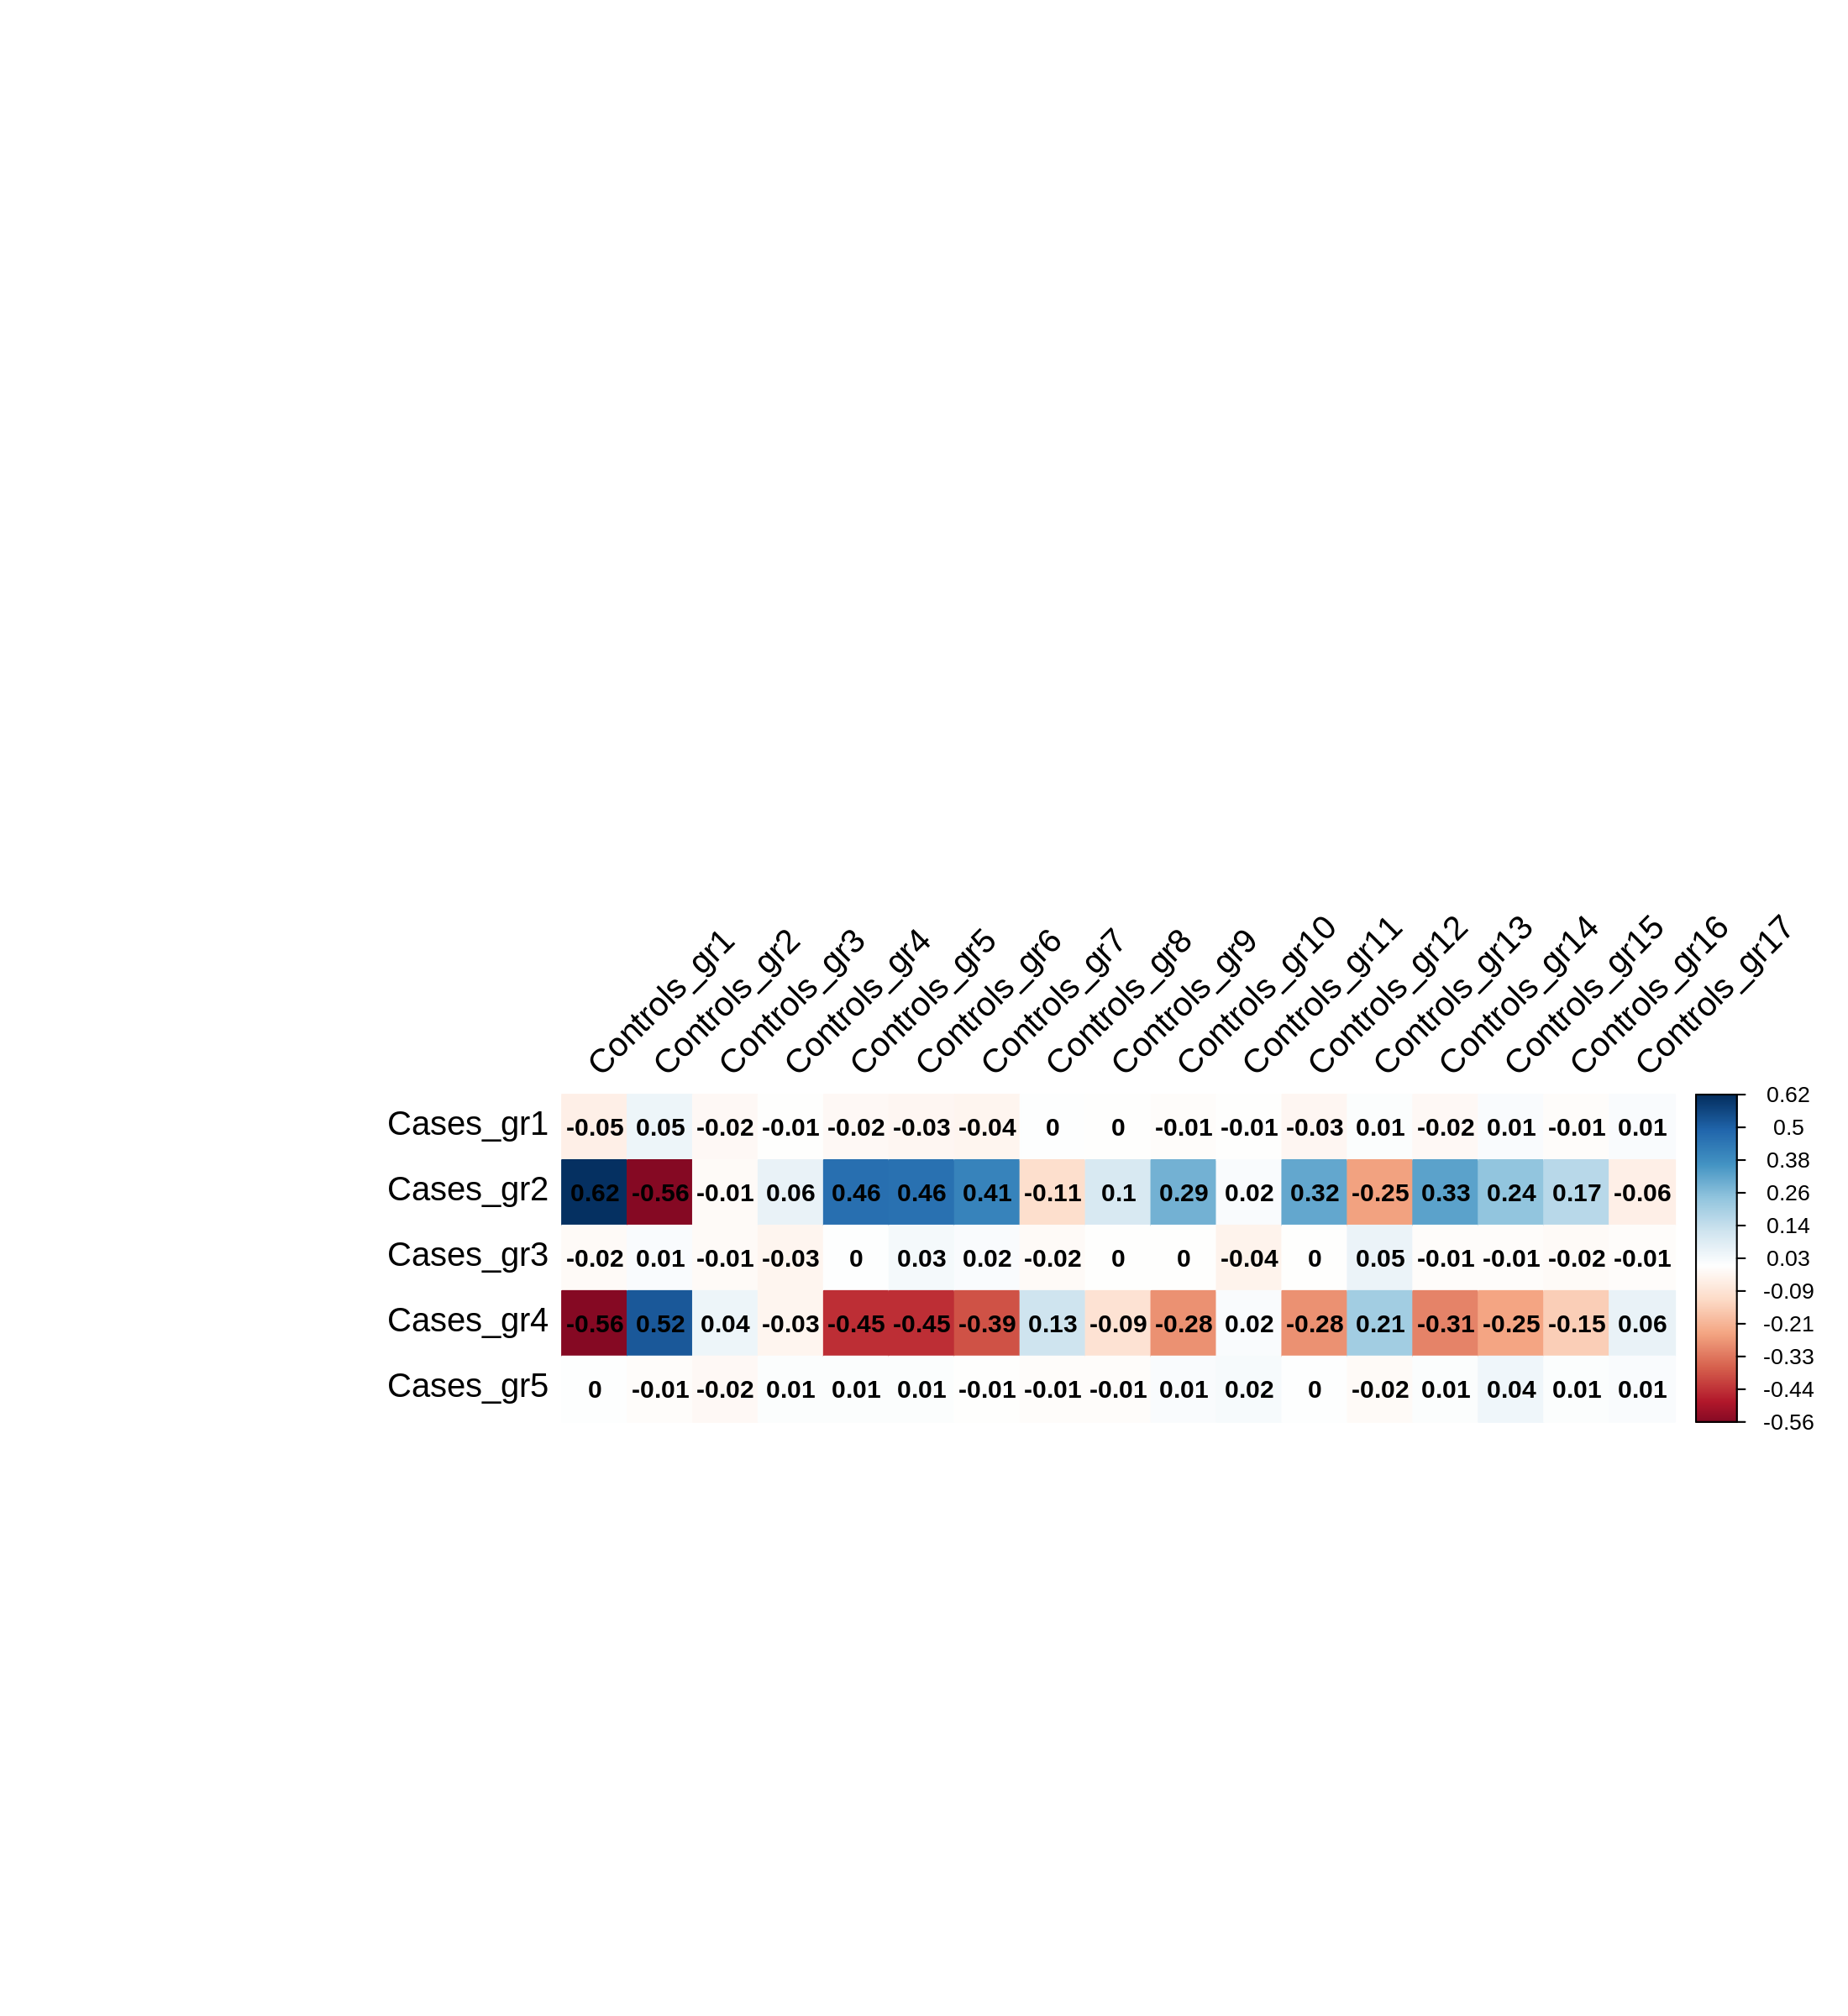

,Controls_gr1,Controls_gr2,Controls_gr3,Controls_gr4,Controls_gr5,Controls_gr6,Controls_gr7,Controls_gr8,Controls_gr9,Controls_gr10,Controls_gr11,Controls_gr12,Controls_gr13,Controls_gr14,Controls_gr15,Controls_gr16,Controls_gr17
Cases_gr1,-0.05293583,0.06330780,-0.041255717,-0.03559205,-0.01493589,-0.011507064,-0.0416152882,-0.048467376,-0.019100368,0.010845167,-0.006903519,-0.034061076,-0.02987393,-0.033212503,0.04992401,-0.021928007,0.038790339
Cases_gr2,0.55367282,-0.59180071,0.046729890,0.09771649,0.36260205,0.354046717,0.3251556445,0.007906544,0.088605071,0.198096471,0.050118223,0.234898114,-0.20798703,0.245302055,0.15201675,0.166807287,-0.024772580
Cases_gr3,-0.06425531,0.05553311,-0.004666120,-0.06024369,-0.02678799,0.029728271,-0.0009621718,-0.031226486,0.019779298,0.003905769,-0.063278658,-0.020427876,0.11648876,0.001656906,-0.04594087,-0.024348193,-0.037201261
Cases_gr4,-0.47994942,0.51229864,0.001957049,-0.04301750,-0.33431565,-0.358272450,-0.2935423676,0.066004347,-0.078927919,-0.209107335,-0.022506435,-0.194630781,0.19458168,-0.220834866,-0.19901782,-0.136979716,0.001434415
Cases_gr5,0.01324724,-0.01027819,-0.027693283,0.01863849,-0.01692345,0.003438726,0.0122237467,-0.055268213,-0.009883269,0.006871806,0.032381259,0.006507883,-0.05401295,0.010630435,0.08953719,0.009571502,0.032586057


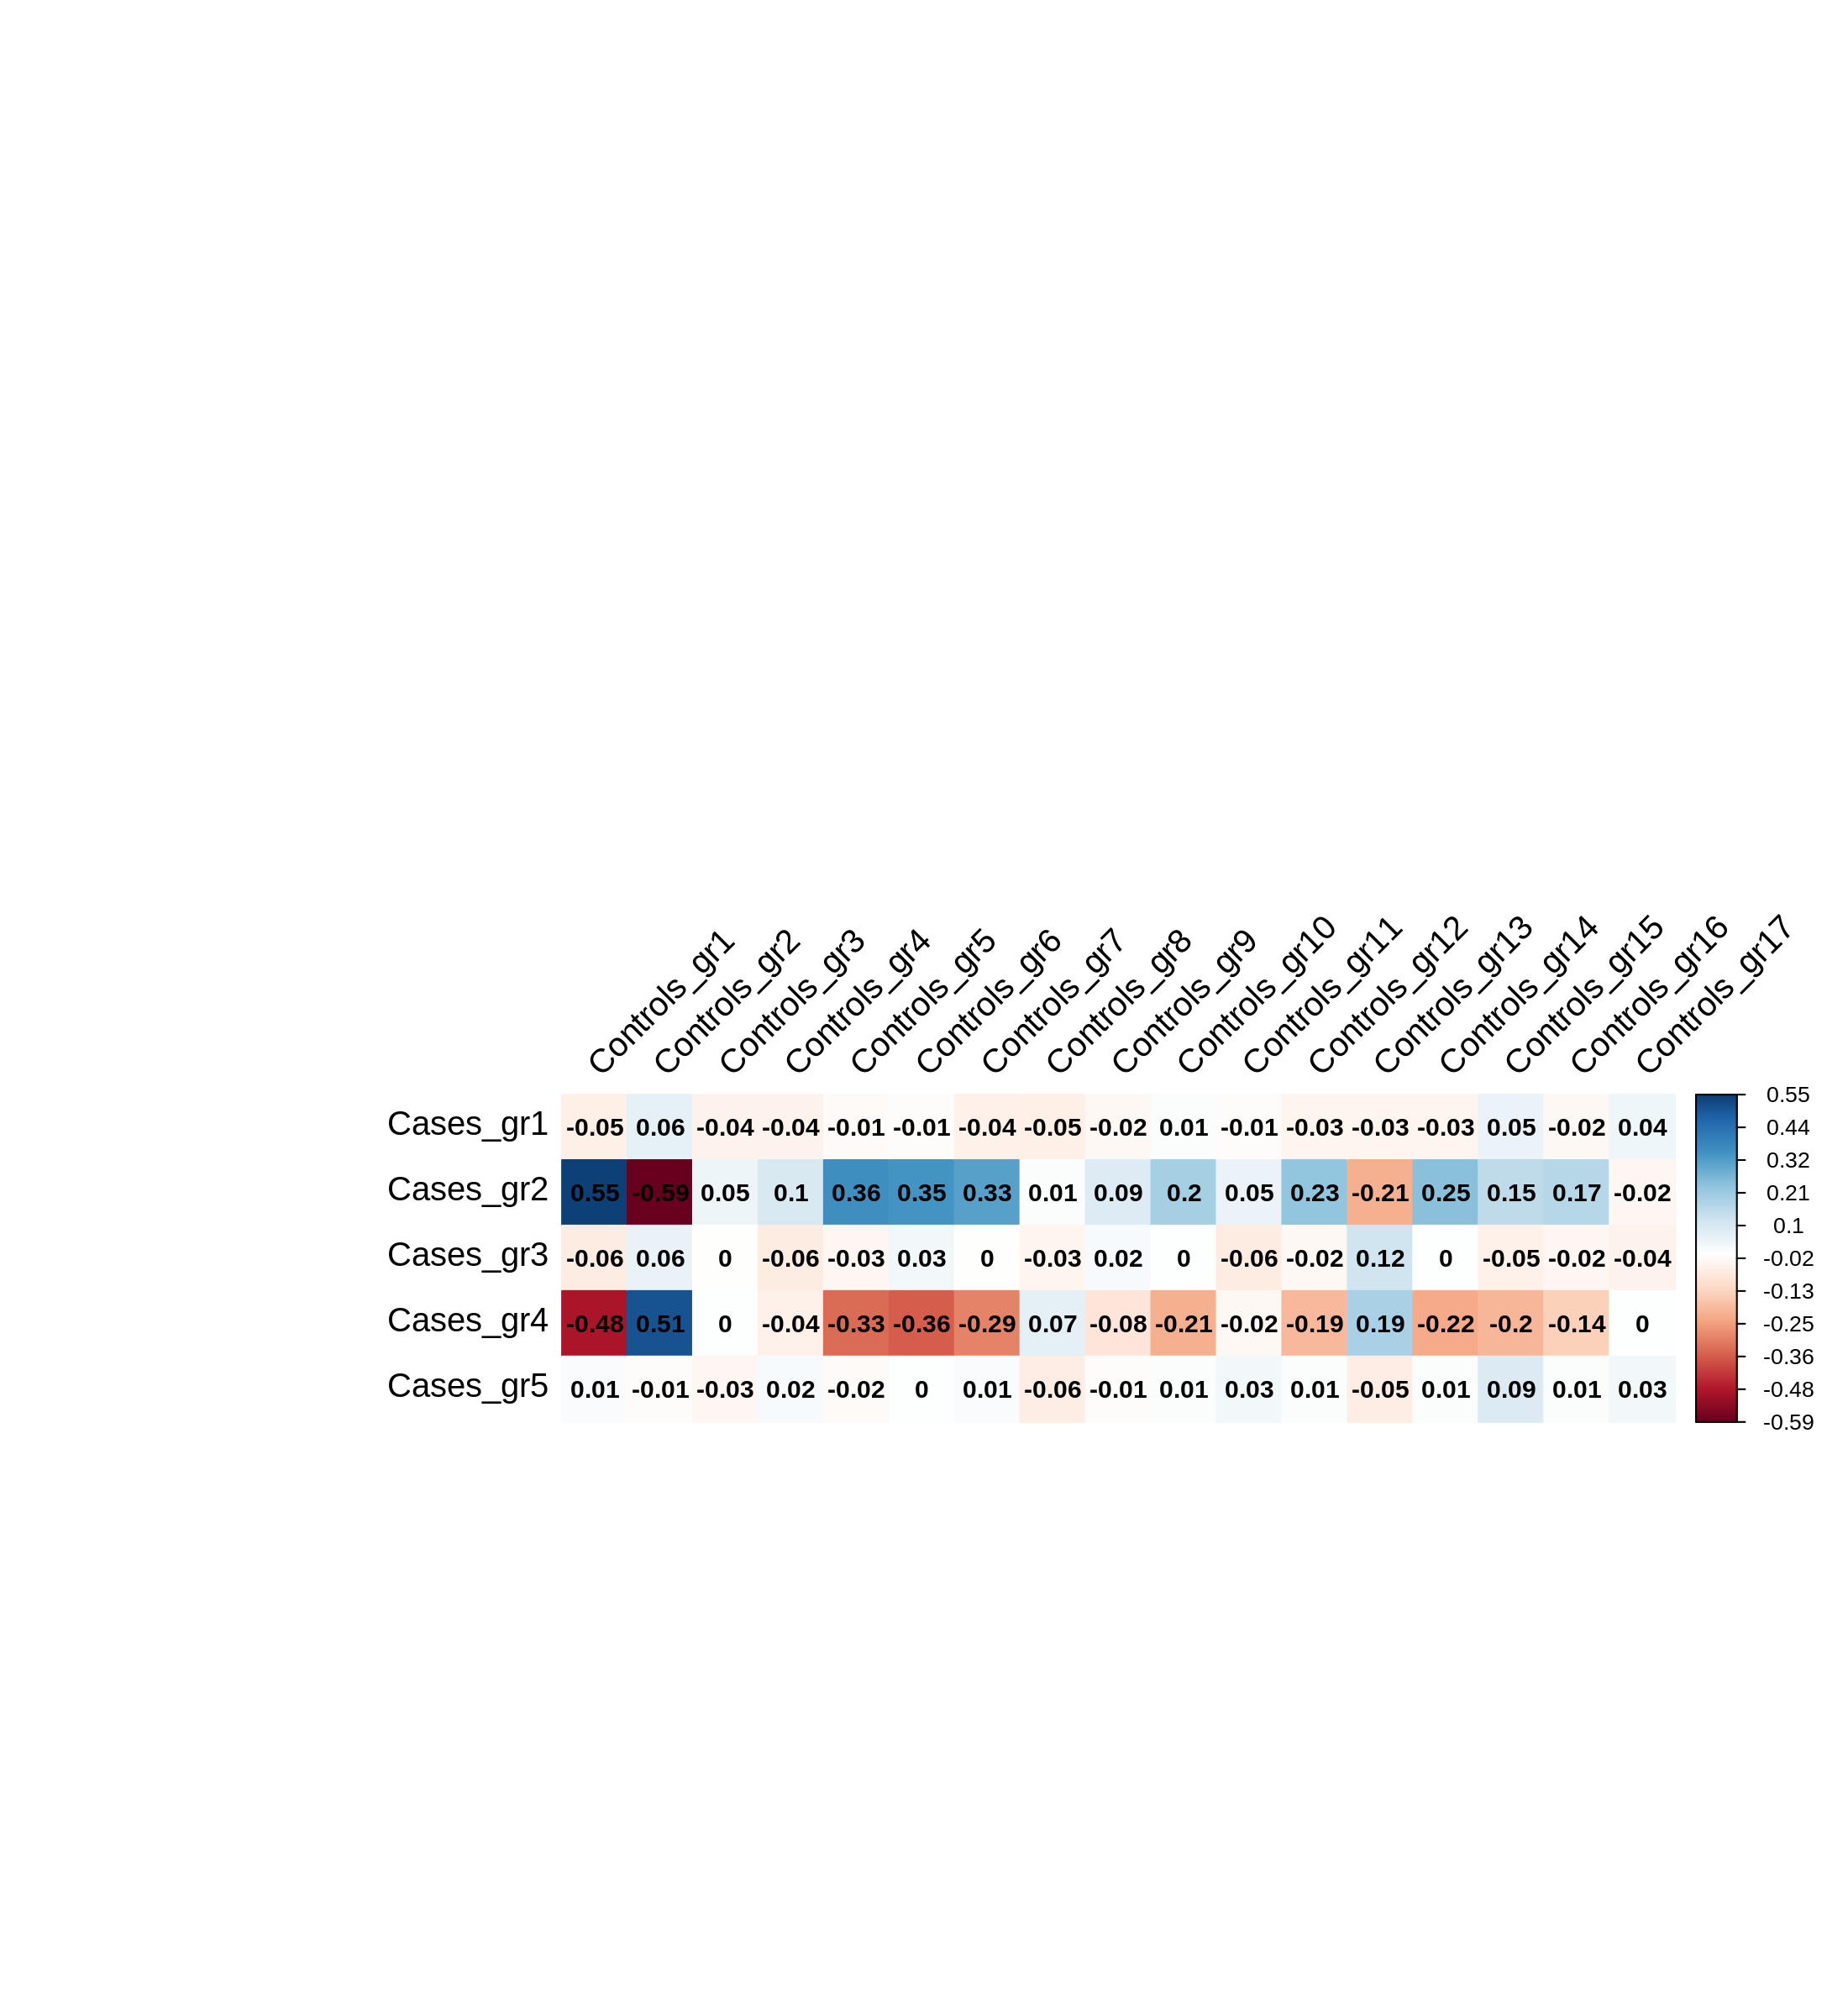

In [10]:
options(repr.plot.width = 11, repr.plot.height = 12, repr.plot.res = 200)
plot_corr_feat(gene_cases, gene_controls_original, outFold, type_data = "Tscores", name_comp_controls = "ControlsOriginal", width_pl = 11, height_pl = 12)
plot_corr_feat(path_cases, path_controls_original, outFold, type_data = "Pathscores", name_comp_controls = "ControlsOriginal", width_pl = 11, height_pl = 12)

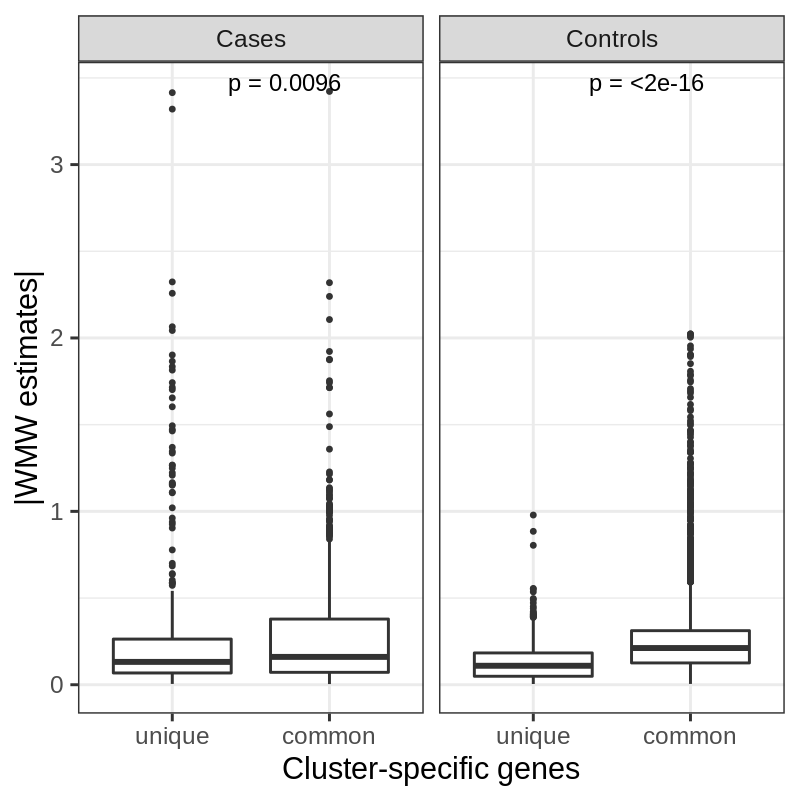

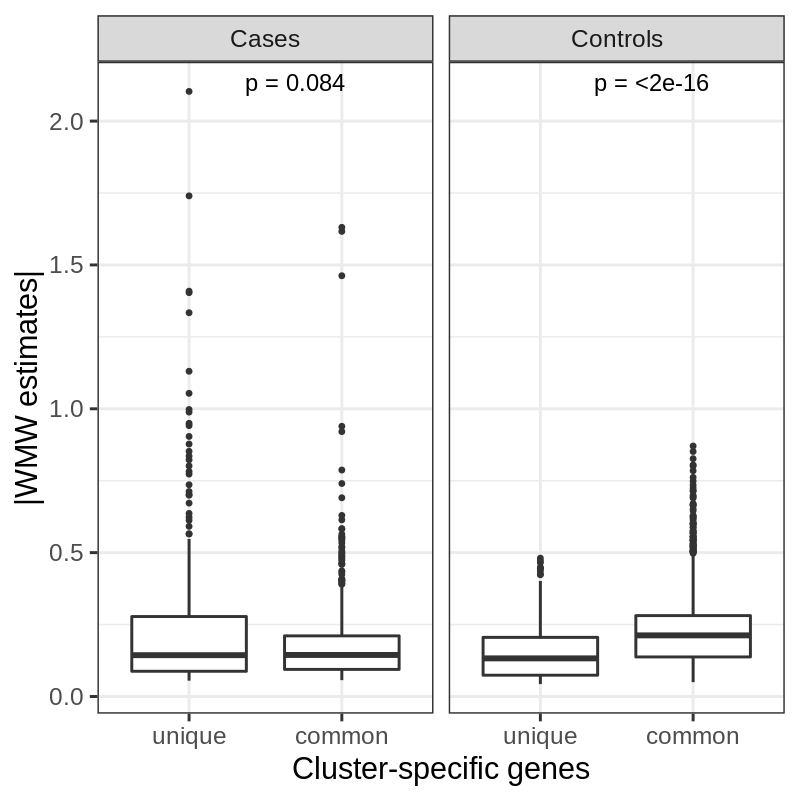

In [64]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200)
plot_intersection(gene_cases, gene_controls_original, outFold, pval_corr_thr = 0.01, type_data = "Tscores", name_comp_controls = "ControlsOriginal", width_pl = 4, height_pl = 4)
plot_intersection(path_cases, path_controls_original, outFold, pval_corr_thr = 0.01, type_data = "Pathscores", name_comp_controls = "ControlsOriginal", width_pl = 4, height_pl = 4)